<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Autocorrelations and time series decomposition



---

## Learning Objectives

### Core

- Calculate and plot autocorrelation and partial autocorrelation coefficients
- Read and interpret the autocorrelation plots
- Obtain a time series decomposition into trend, seasonal and residual components
- Know about stationarity as an important model requirement
- Use differencing to remove (polynomial) trends

### Target

- Know about differences between pandas and statsmodels auotcorrelation functions

<h1>Lesson Guide<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Learning-Objectives" data-toc-modified-id="Learning-Objectives-1">Learning Objectives</a></span><ul class="toc-item"><li><span><a href="#Core" data-toc-modified-id="Core-1.1">Core</a></span></li><li><span><a href="#Target" data-toc-modified-id="Target-1.2">Target</a></span></li></ul></li><li><span><a href="#Load-the-Unemployment-Data" data-toc-modified-id="Load-the-Unemployment-Data-2">Load the Unemployment Data</a></span></li><li><span><a href="#Create-a-Datetime-Index" data-toc-modified-id="Create-a-Datetime-Index-3">Create a Datetime Index</a></span></li><li><span><a href="#Visually-Examine-the-Unemployment-Rate" data-toc-modified-id="Visually-Examine-the-Unemployment-Rate-4">Visually Examine the Unemployment Rate</a></span></li><li><span><a href="#Autocorrelation-and-the-Autocorrelation-Function-(ACF)" data-toc-modified-id="Autocorrelation-and-the-Autocorrelation-Function-(ACF)-5">Autocorrelation and the Autocorrelation Function (ACF)</a></span><ul class="toc-item"><li><span><a href="#Computing-Autocorrelation" data-toc-modified-id="Computing-Autocorrelation-5.1">Computing Autocorrelation</a></span></li><li><span><a href="#Autocorrelation-Using-Statsmodels" data-toc-modified-id="Autocorrelation-Using-Statsmodels-5.2">Autocorrelation Using Statsmodels</a></span></li></ul></li><li><span><a href="#Partial-Autocorrelation-and-the-Partial-Autocorrelation-Function-(PACF)" data-toc-modified-id="Partial-Autocorrelation-and-the-Partial-Autocorrelation-Function-(PACF)-6">Partial Autocorrelation and the Partial Autocorrelation Function (PACF)</a></span></li><li><span><a href="#Time-Series-Decomposition" data-toc-modified-id="Time-Series-Decomposition-7">Time Series Decomposition</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Questions:" data-toc-modified-id="Questions:-7.0.1">Questions:</a></span></li></ul></li></ul></li><li><span><a href="#Differencing-a-time-series-and-stationarity" data-toc-modified-id="Differencing-a-time-series-and-stationarity-8">Differencing a time series and stationarity</a></span><ul class="toc-item"><li><span><a href="#Difference-the-unemployment-rate-and-plot" data-toc-modified-id="Difference-the-unemployment-rate-and-plot-8.1">Difference the unemployment rate and plot</a></span></li><li><span><a href="#Compare-the-(partial)-autocorrelations-of-the-differenced-and-original-time-series" data-toc-modified-id="Compare-the-(partial)-autocorrelations-of-the-differenced-and-original-time-series-8.2">Compare the (partial) autocorrelations of the differenced and original time series</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-8.3">Conclusions</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the Unemployment Data

This is historical quarterly data regarding unemployment rates in the United States. First, perform any necessary cleaning.

In [2]:
data = pd.read_csv(
    '../../../../resource-datasets/unemployment_timeseries/seasonally-adjusted-quarterly-us.csv')
data.dropna(inplace=True)

In [3]:
data.head()

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
0,1948Q1,3.733%
1,1948Q2,3.667%
2,1948Q3,3.767%
3,1948Q4,3.833%
4,1949Q1,4.667%


In [4]:
data.columns = ['year_quarter', 'unemployment_rate']
data['unemployment_rate'] = data['unemployment_rate'].map(
    lambda x: float(str(x).replace('%', '')))
data.dropna(inplace=True)

## Create a Datetime Index

This is quarterly data, so converting to datetime is a bit complicated. `.dt.to_period('Q')` will help us represent the string as a datetime object.

In [5]:
data['date'] = pd.to_datetime(data.year_quarter).dt.to_period('Q')
data.set_index('date', inplace=True, drop=True)
# data.index = data.index.to_timestamp()
data.head()

,year_quarter,unemployment_rate
date,,
1948-01-01,1948Q1,3.733
1948-04-01,1948Q2,3.667
1948-07-01,1948Q3,3.767
1948-10-01,1948Q4,3.833
1949-01-01,1949Q1,4.667


## Visually Examine the Unemployment Rate

Plot the unemployment rate.

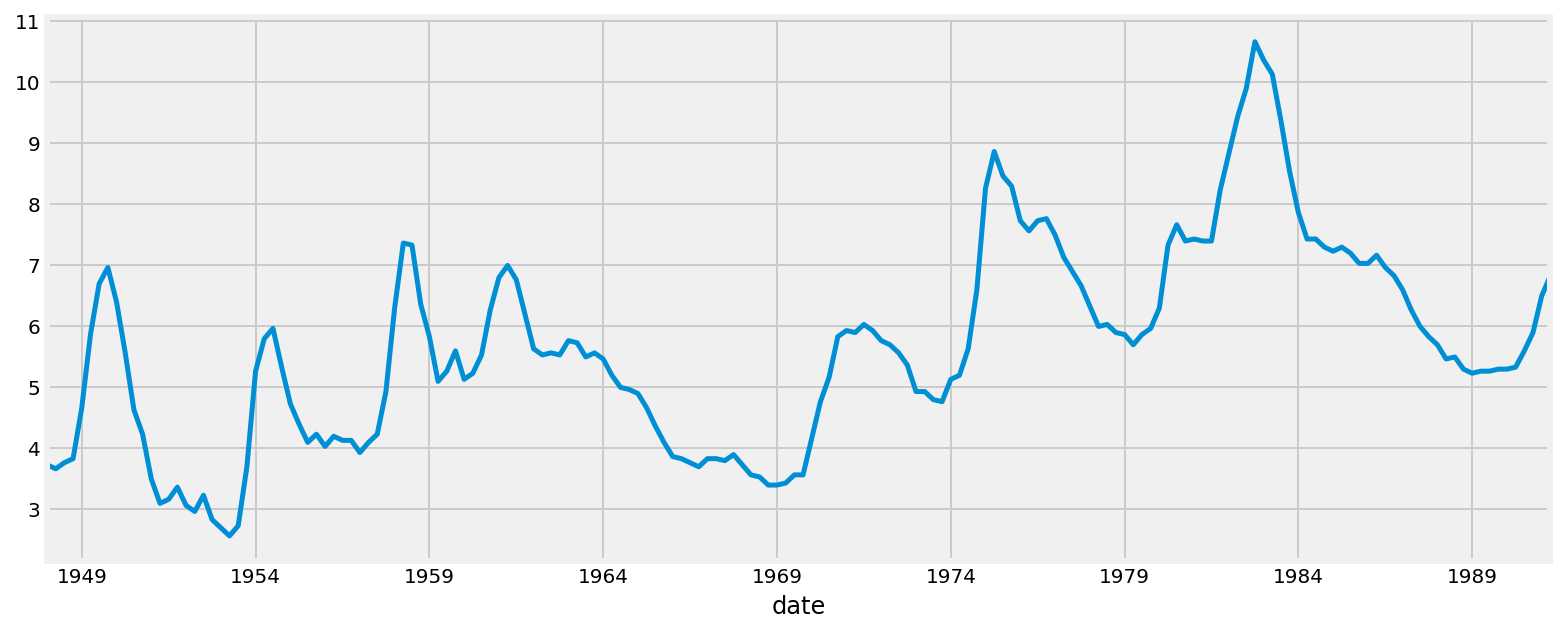

In [6]:
data['unemployment_rate'].plot(lw=2.5, figsize=(12, 5))
plt.show()

##  Autocorrelation and the Autocorrelation Function (ACF)

In previous weeks, our analyses have been concerned with the correlation between two or more variables (height and weight, education and salary, etc.). In time series data, autocorrelation is a measure of _how correlated a variable is with itself_.

Specifically, autocorrelation measures how closely earlier values relate to values that occur later in time.

Examples of autocorrelation are:

    In stock market data, the stock price at one point is correlated with the stock 
    price of the point that's directly prior in time. 
    
    In sales data, sales on a Saturday are likely correlated with 
    sales on the next Saturday and the previous Saturday, as well as other days to more
    or less of an extent.

Below is the formula for the autocorrelation function (ACF):

Given measurements $x_1, x_2, x_3, \ldots, x_n$ at time points $t_1, t_2, t_3, \ldots, t_n$:

$${\rm acf}({\rm lag_k}) = \frac{\sum_{t=k+1}^{n}\left(\;x_t - \bar{x}\;\right)\left(\;x_{t-k} - \bar{x}\;\right)}{\sum_{t=1}^n\left(\;x_t - \bar{x}\;\right)^2}$$

Compare this to the formula for correlation:

Given measurements $x_1, x_2, x_3, \ldots, x_n$ and measurements $y_1, y_2, y_3, \ldots, y_n$:

$$r_{xy} = \frac{\sum_{i=1}^{n}\left(\;x_i - \bar{x}\;\right)\left(\;y_{i} - \bar{y}\;\right)}{\sqrt{\left(\sum_{i=1}^{n}\left(\;x_i - \bar{x}\;\right)^2\sum_{i=1}^n\left(\;y_i - \bar{y}\;\right)^2\right)}}$$


In this sum, the **lag** $k$ indicates to sum over all pairs of points which are that lag apart.

### Computing Autocorrelation

To compute autocorrelation, we fix a lag, _k_, which is the delta between the given point and the prior point used to compute the correlation.

With a _k_ value of 1, we'd compute how correlated a value is with the value that's immediately prior. With a _k_ value of 10, we'd compute how correlated a variable is with the value that's 10 time points prior.

In [7]:
urate = data.unemployment_rate

In [8]:
np.array([urate.autocorr(lag=k) for k in range(20)])

array([1.        , 0.96480692, 0.88457618, 0.78647225, 0.69154374,
       0.61535186, 0.56076382, 0.5208759 , 0.48991528, 0.46634242,
       0.4434692 , 0.41783184, 0.39321798, 0.37490436, 0.36294138,
       0.36032148, 0.36243806, 0.3588273 , 0.34360617, 0.31740037])

That is the way how pandas calculates autocorrelations:

In [9]:
def pandas_autocorr(y, lag=1):
    X = pd.DataFrame({'a': y, 'b': y.shift(lag)}).copy()
    X.dropna(inplace=True)
    autocorr = X.corr().iloc[0, 1]
    return autocorr

In [10]:
np.array([pandas_autocorr(urate, lag=k) for k in range(20)])

array([1.        , 0.96480692, 0.88457618, 0.78647225, 0.69154374,
       0.61535186, 0.56076382, 0.5208759 , 0.48991528, 0.46634242,
       0.4434692 , 0.41783184, 0.39321798, 0.37490436, 0.36294138,
       0.36032148, 0.36243806, 0.3588273 , 0.34360617, 0.31740037])

### Autocorrelation Using Statsmodels

Statsmodels comes with some convenient packages for calculating and plotting autocorrelation. Load up these two functions and try them out:

```python
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
```

In [11]:
from statsmodels.tsa.stattools import acf

Note that statsmodels calculates autocorrelations in a slightly different way:

In [12]:
acf(urate, nlags=20)

array([1.        , 0.95950578, 0.87513008, 0.77480906, 0.67860558,
       0.60302767, 0.54946953, 0.50980855, 0.47862666, 0.45530485,
       0.43290704, 0.40733564, 0.38242446, 0.36262662, 0.34831031,
       0.34311303, 0.34269765, 0.33602242, 0.31802897, 0.29043284,
       0.25556895])

In [13]:
def statsmodel_autocorr(y, lag=1):

    if lag == 0:
        return 1.0

    else:
        X = pd.DataFrame({'a': y.values[:-lag], 'b': y.values[lag:]})

        numerator = np.sum((X.loc[:, 'a']-y.mean())*(X.loc[:, 'b']-y.mean()))
        denom = ((y-y.mean())**2).sum()
        autocorr = numerator/denom

        return autocorr

In [14]:
np.array([statsmodel_autocorr(urate, lag=k) for k in range(20)])

array([1.        , 0.95950578, 0.87513008, 0.77480906, 0.67860558,
       0.60302767, 0.54946953, 0.50980855, 0.47862666, 0.45530485,
       0.43290704, 0.40733564, 0.38242446, 0.36262662, 0.34831031,
       0.34311303, 0.34269765, 0.33602242, 0.31802897, 0.29043284])

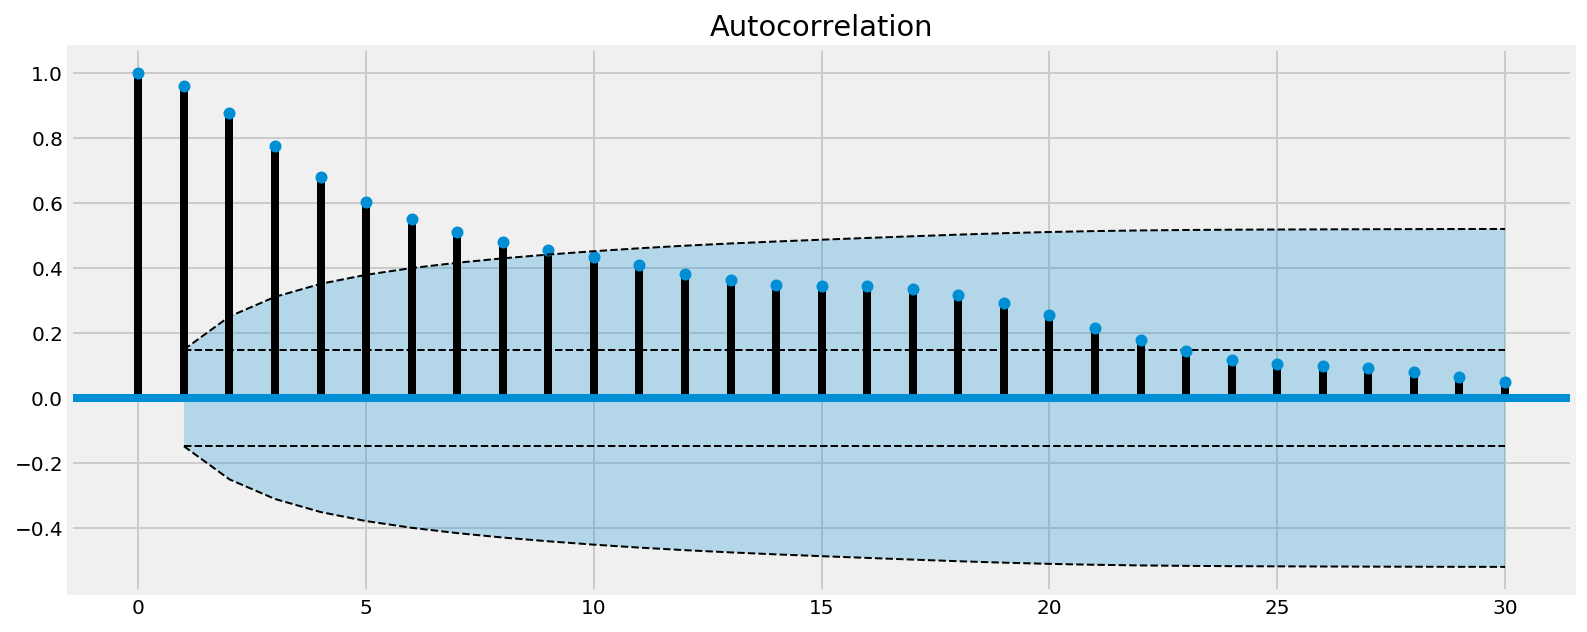

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

lags = 30
se = 1.96/np.sqrt(len(urate))
bartlett = np.sqrt((-1+2*np.cumsum(acf(urate, nlags=lags-1)**2)))

fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(urate, lags=lags, ax=ax)
ax.hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
ax.plot(range(1, lags+1), se*bartlett, c='k', ls='--', lw=1)
ax.plot(range(1, lags+1), -se*bartlett, c='k', ls='--', lw=1)
plt.show()

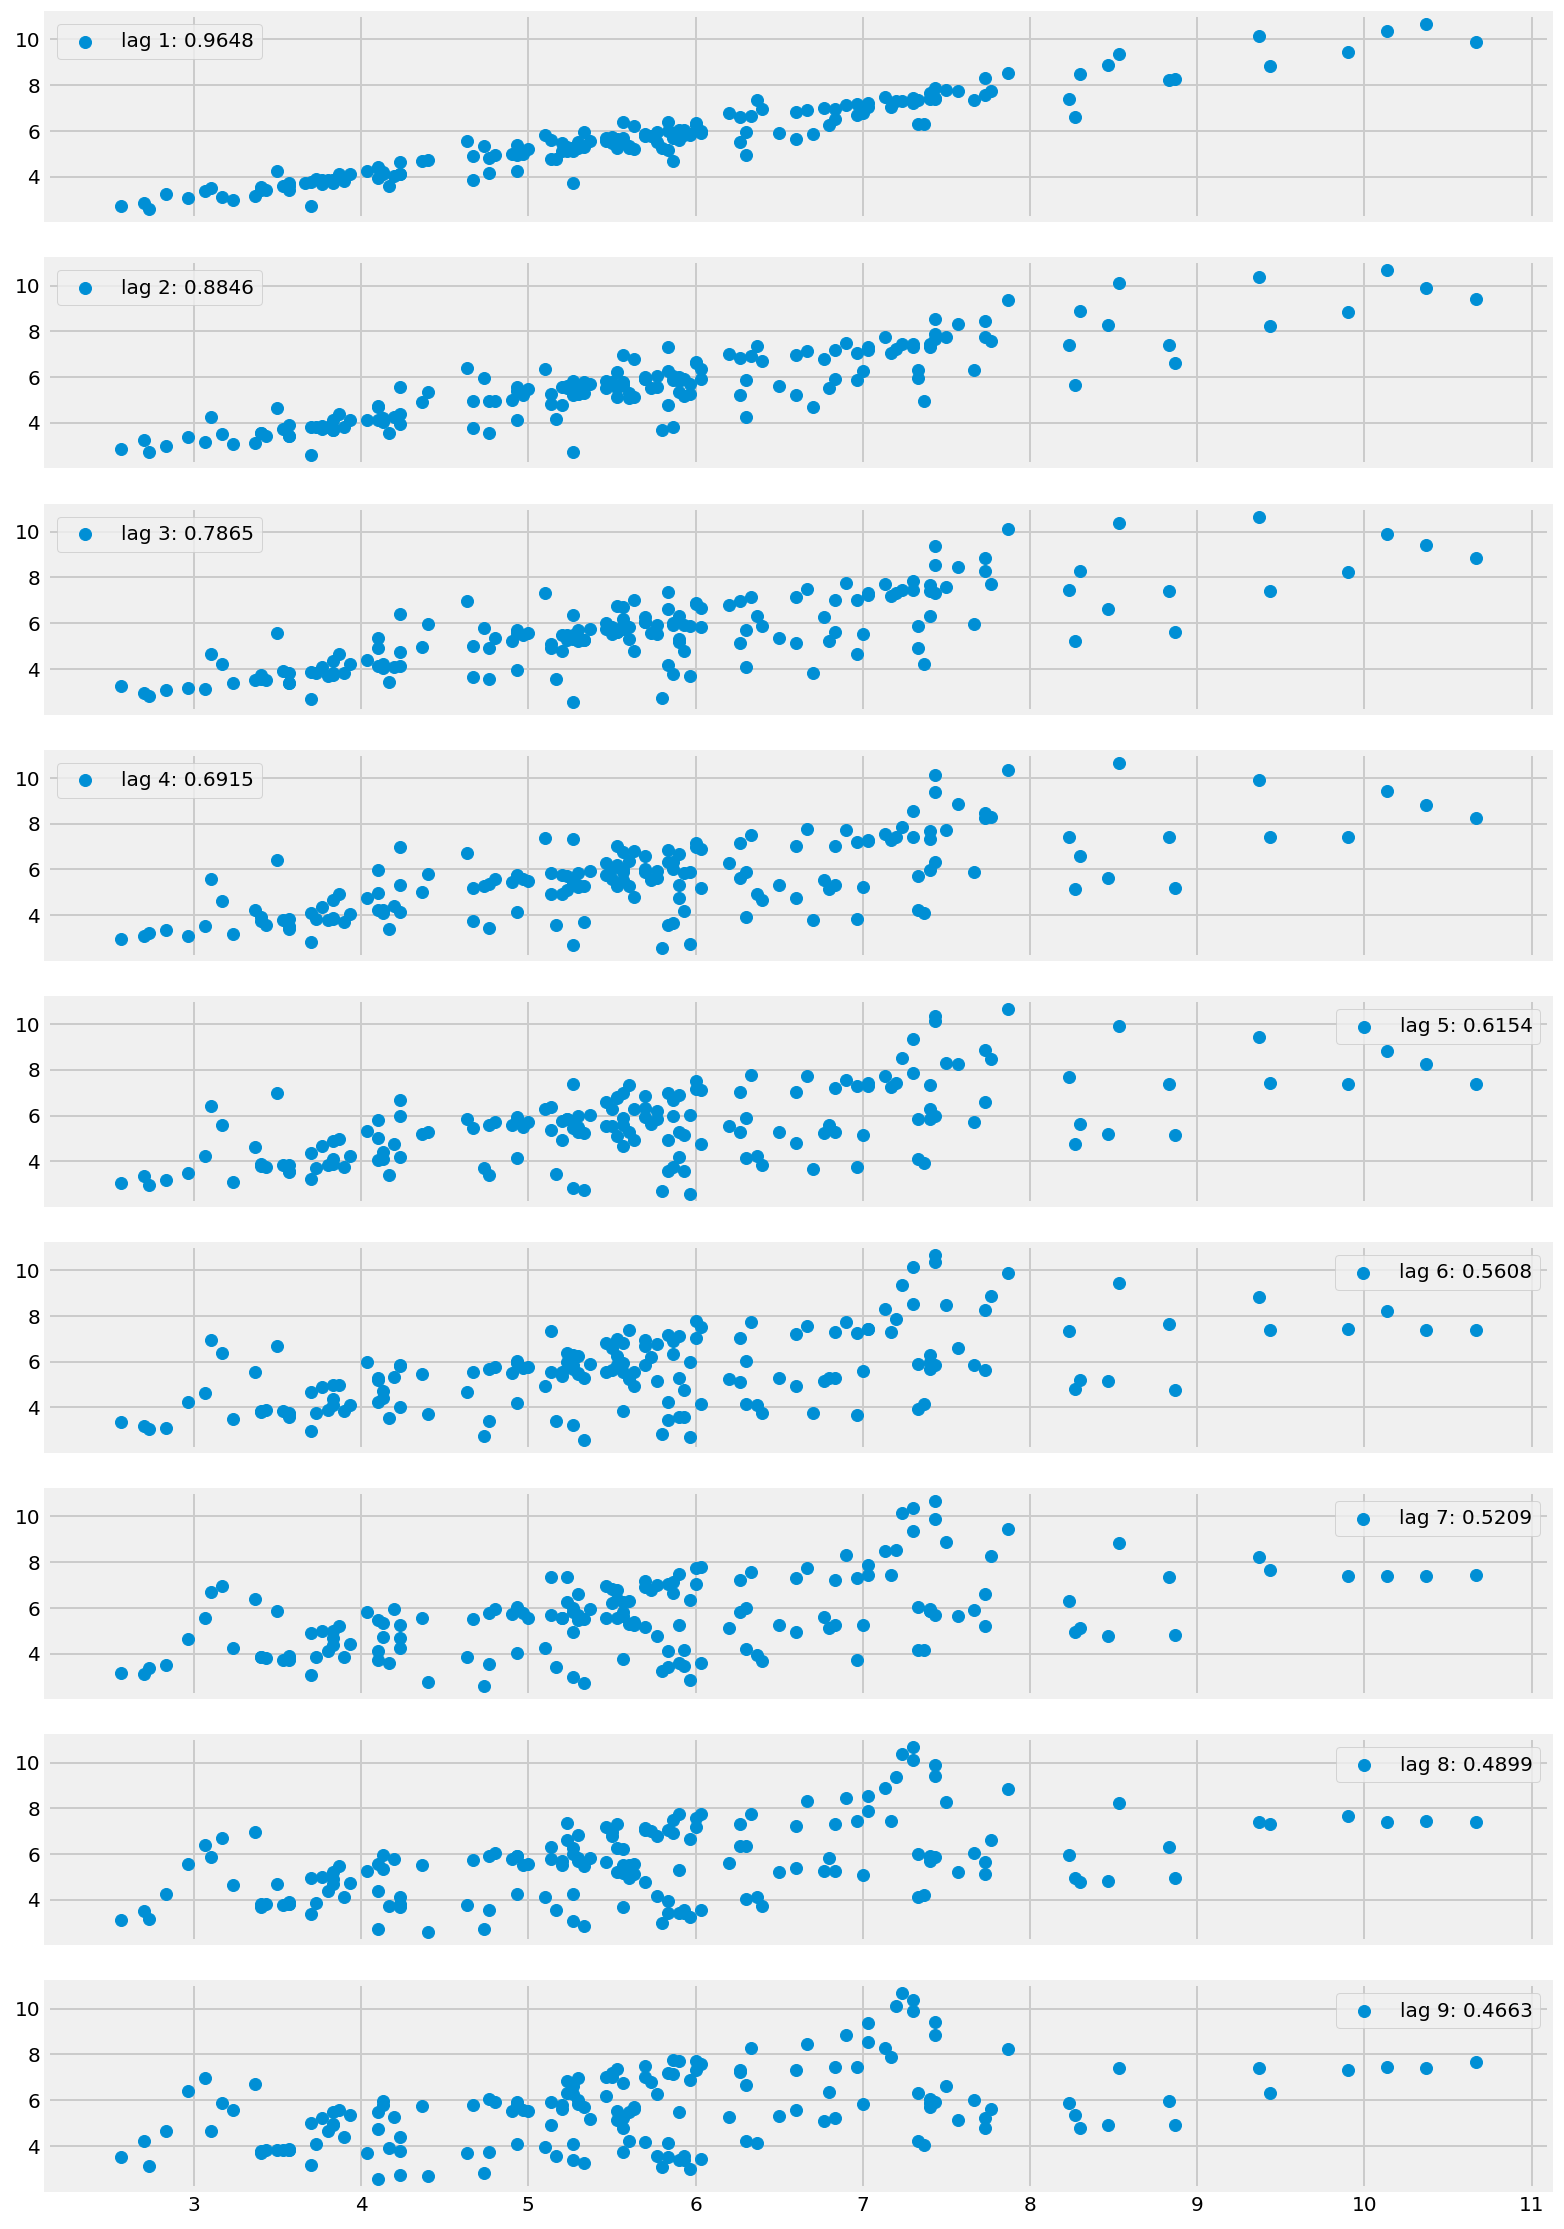

In [16]:
fig, ax = plt.subplots(nrows=9, sharex=True, figsize=(12, 20))
for i in range(1, 10):
    ax[i-1].scatter(urate.iloc[i:], urate.shift(i).dropna(), 
                    label=f'lag {i}: {round(urate.autocorr(lag=i), 4)}')
    ax[i-1].legend()
plt.show()

## Partial Autocorrelation and the Partial Autocorrelation Function (PACF)


Another important chart for diagnosing your time series is the partial autocorrelation chart (PACF). This is similar to autocorrelation, but, instead of being just the correlation at increasing lags, it is the correlation at a given lag, _controlling for the effect of lags in between._

Load up the sister functions for partial autocorrelation from Statsmodels and test them out on the differenced time series.

```python
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
```

In [17]:
from statsmodels.tsa.stattools import pacf

In [18]:
pacf(urate, nlags=20)

array([ 1.        ,  0.96505205, -0.67010933,  0.21691526,  0.07494577,
        0.21322536, -0.09593115, -0.05491075,  0.07521878,  0.14700603,
       -0.18064033, -0.01381037,  0.1414165 ,  0.13517355, -0.10704305,
        0.10418921, -0.0958789 , -0.08324834, -0.07692577,  0.08321147,
       -0.05132902])

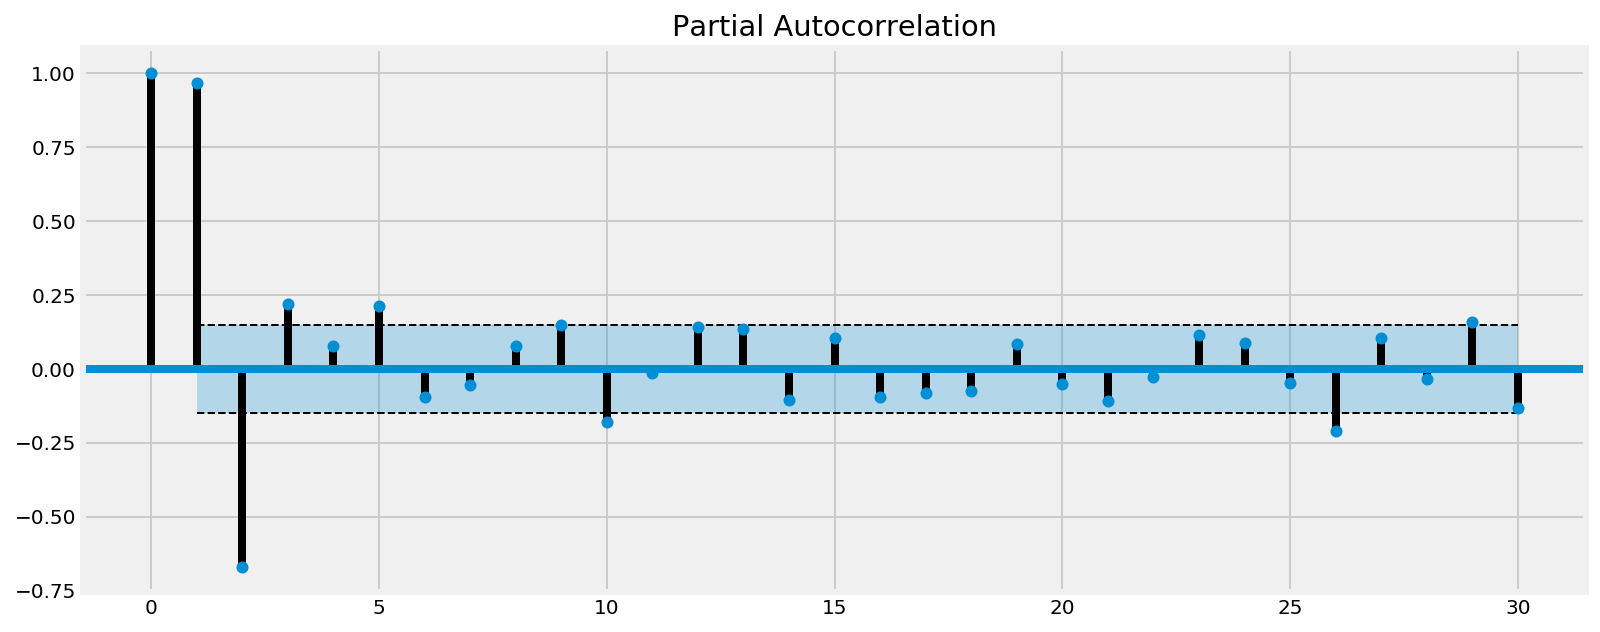

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(urate, lags=30, ax=ax)
ax.hlines(np.array([-1, 1])*se,
          1, 30, linestyles='--', lw=1)
plt.show()

The time series models we are going to consider try to capture the information contained in the (partial) autocorrelations.

Let's create a function to display autocorrelations and partial autocorrelations together.

In [20]:
def autocorr_plots(y, lags=20, alpha=0.05):
    """
    Plot autocorrelations and partial autocorrelations
    Arguments:
    y: Time series
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """

    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))

    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    return fig, ax

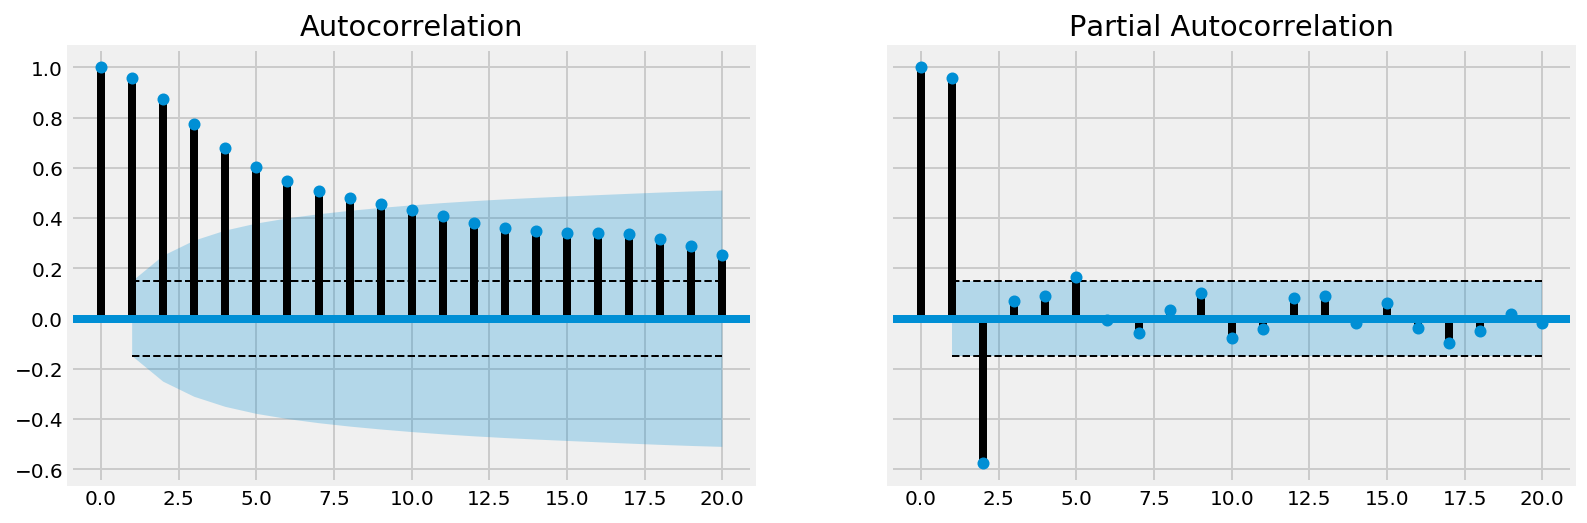

In [21]:
fig, ax = autocorr_plots(urate, lags=20)

## Time Series Decomposition

$$ Y_t = T_t + S_t + R_t $$

- $Y_t = $ observed value at time $t$
- $T_t = $ trend component, *long-term behavior*
- $S_t = $ seasonality component, *periodic fluctuations*
- $R_t = $ residual, *non-periodic fluctuations*


> The decomposition above is additive; it can also be multiplicative.


There are several algorithms for performing this decomposition

- Classical decomp., [https://www.otexts.org/fpp/6/3](https://www.otexts.org/fpp/6/3)
- X-12-ARIMA, [https://www.otexts.org/fpp/6/4](https://www.otexts.org/fpp/6/4)
- STL, [https://www.otexts.org/fpp/6/5](https://www.otexts.org/fpp/6/5)

See also `seasonal_decompose` in `statsmodel.tsa.seasonal`.  

> Nice tutorial here: [http://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/](http://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)


#### Questions:

- *What is the long-term behavior of my series?*
- *How does my time series fluctuate?*


In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

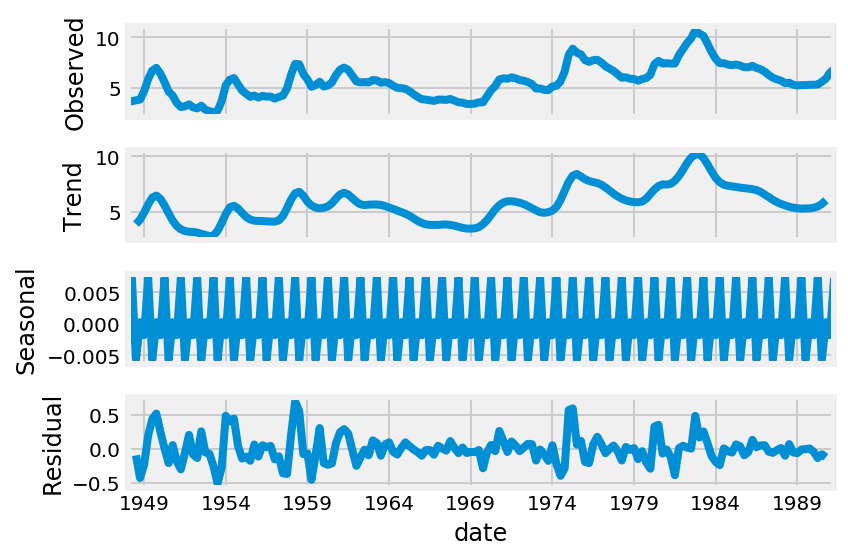

In [23]:
result = seasonal_decompose(urate, freq=4)
result.plot()
plt.show()

In [24]:
result.resid[:10]

date
1948-01-01         NaN
1948-04-01         NaN
1948-07-01   -0.094035
1948-10-01   -0.425747
1949-01-01   -0.231318
1949-04-01    0.201224
1949-07-01    0.438840
1949-10-01    0.520753
1950-01-01    0.251682
1950-04-01    0.009724
Freq: QS-OCT, Name: unemployment_rate, dtype: float64

## Differencing a time series and stationarity

If a time series is stationary, the mean, variance, and covariance are unchanged by time shifts. Forecasting methods typically assume that the time series you are forecasting on are stationary, or at least approximately stationary. For any two instances in time t and s one has:

$${\rm E}(Y_t) = \mu$$
$${\rm Var}(Y_t) =  \sigma^2$$
$${\rm Cov}(Y_t, Y_s) =  \gamma(|t - s|)$$

The last relation implies that the covariance between two time points depends only on the time difference between them, the so-called lag, i.e. taking t=10, s=20 or t=15, s=25 would give the same covariance.

If a time series is not stationary, often it can be transformed to a stationary form. The most common way to make a time series stationary is to perform "differencing". This procedure converts a time series into the difference between consecutive values:
 
$$\Delta Y_t = Y_t - Y_{t-1}$$

This removes polynomial trends in the time series. In the case of a linear trend, there will only be a need for a single differencing, but otherwise taking further differences might be required to remove trends. If the trend is not of polynomial type, it might be convenient to transform the data first (e.g. by taking the log, square root, etc.).

Here, we will limit to inspection by eye to judge if a time series is stationary to a sufficient degree. There are also statistical tests available to check for stationarity, e.g.

- [(Augmented) Dickey-Fuller test]( https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
 - [statsmodels implementation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)
- [Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test](https://en.wikipedia.org/wiki/KPSS_test)
 - [statsmodels implementation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html)

### Difference the unemployment rate and plot

In [25]:
data['unemp_diff'] = data['unemployment_rate'].diff()

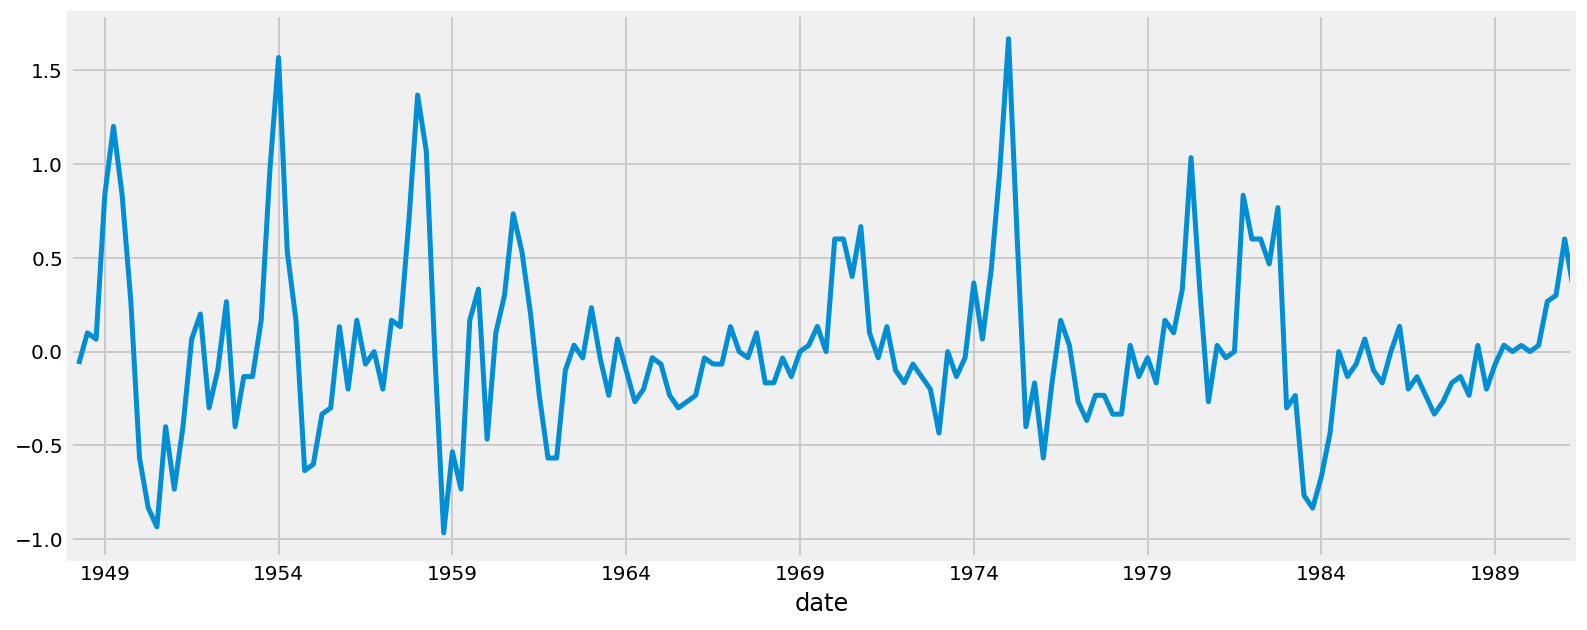

In [26]:
data['unemp_diff'].plot(lw=2.5, figsize=(12, 5))
plt.show()

### Compare the (partial) autocorrelations of the differenced and original time series

> Note: Remove missing values from the differenced time series.

How is it if you even difference twice?

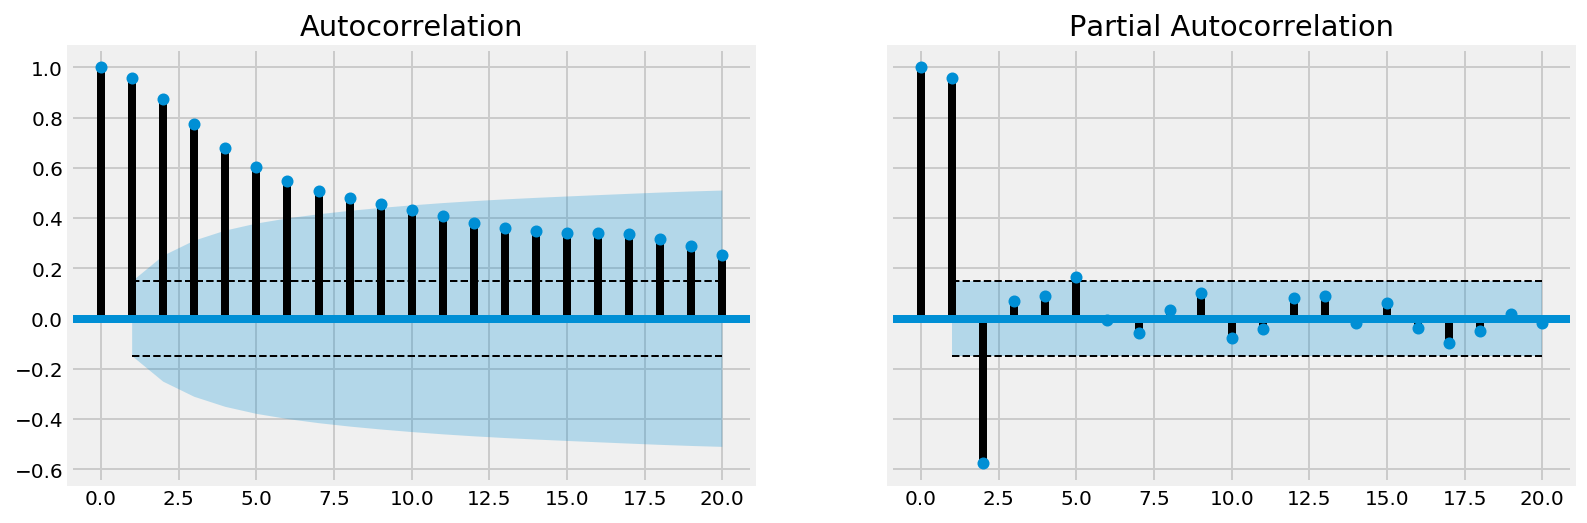

In [27]:
fig, ax = autocorr_plots(urate, lags=20)

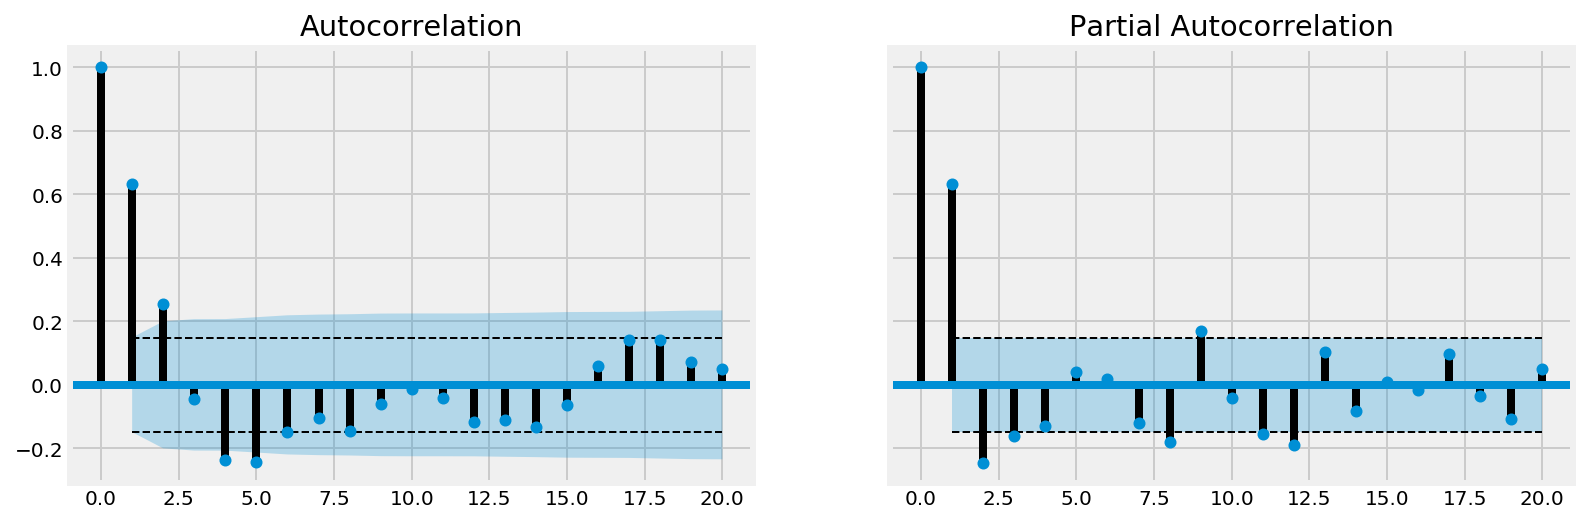

In [28]:
fig, ax = autocorr_plots(urate.diff()[1:], lags=20)

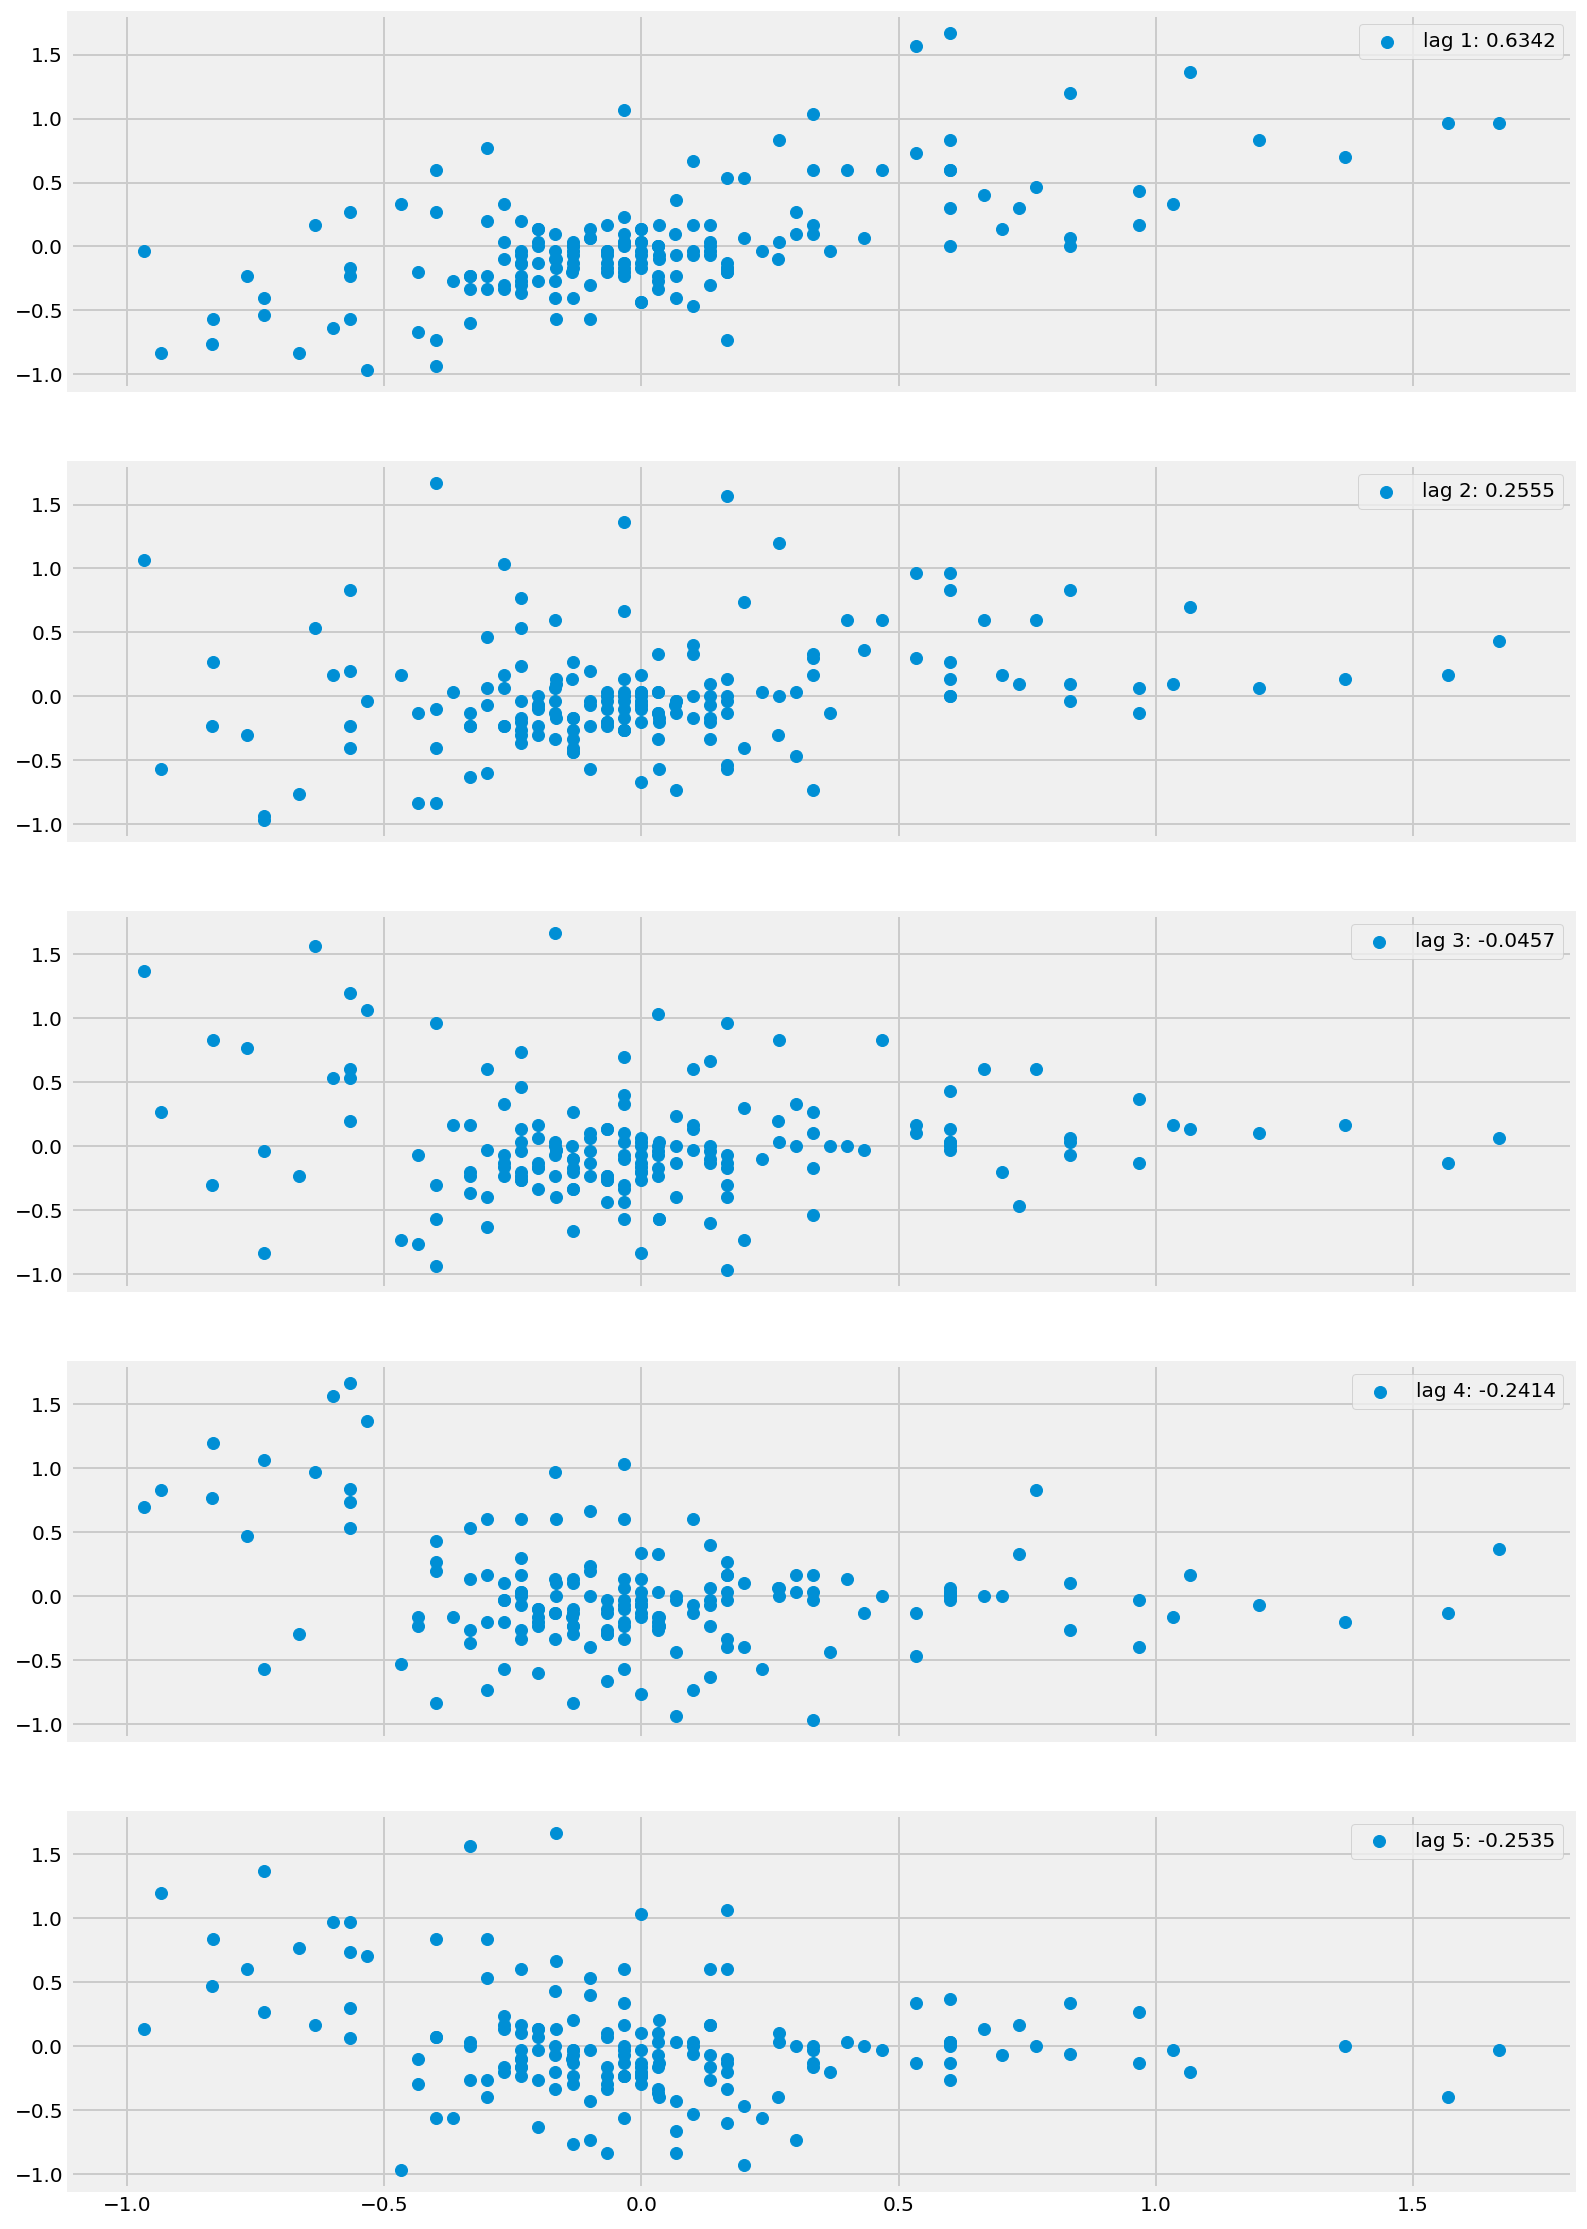

In [29]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(12, 20))
for i in range(1, 6):
    ax[i-1].scatter(urate.diff()[1:].iloc[i:], urate.diff()[1:].shift(i).dropna(), 
                    label=f'lag {i}: {round(urate.diff()[1:].autocorr(lag=i), 4)}')
    ax[i-1].legend()
plt.show()

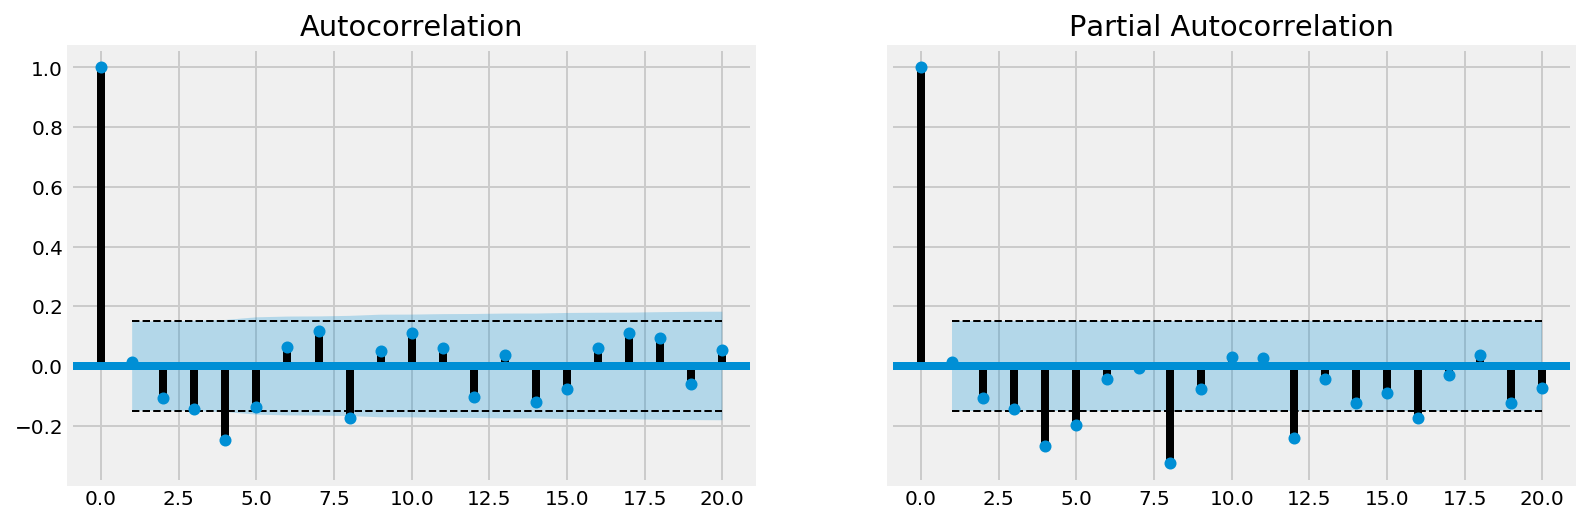

In [30]:
fig, ax = autocorr_plots(urate.diff().diff()[2:], lags=20)

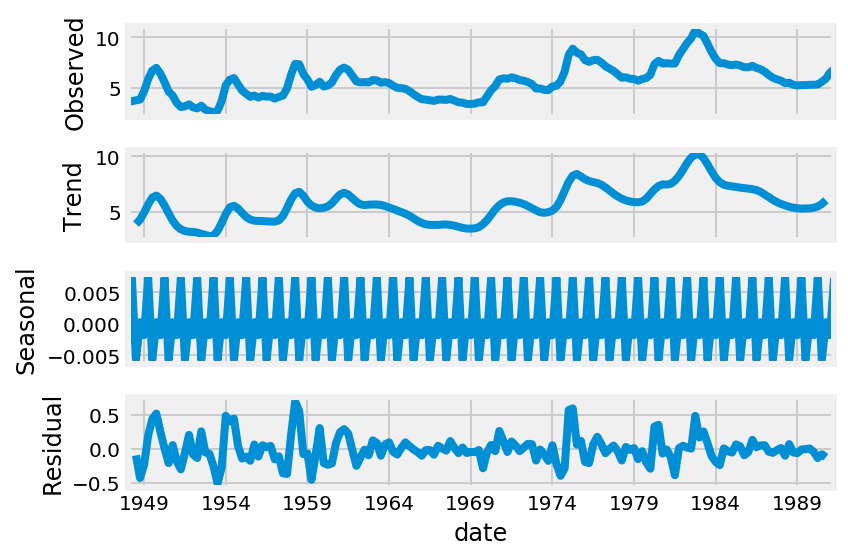

In [31]:
decomp = seasonal_decompose(urate, freq=4)
decomp.plot()
plt.show()

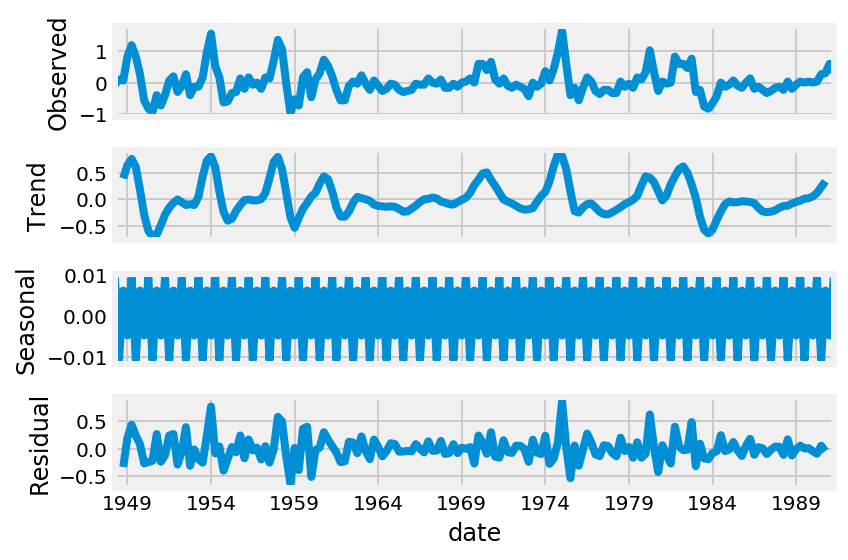

In [32]:
decomp = seasonal_decompose(urate.diff()[1:])
decomp.plot()
plt.show()

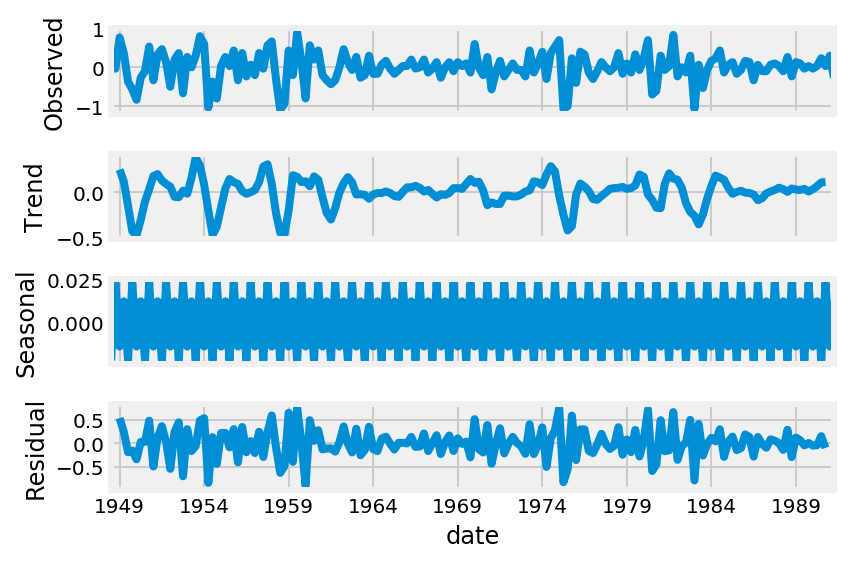

In [33]:
decomp = seasonal_decompose(urate.diff().diff()[2:])
decomp.plot()
plt.show()

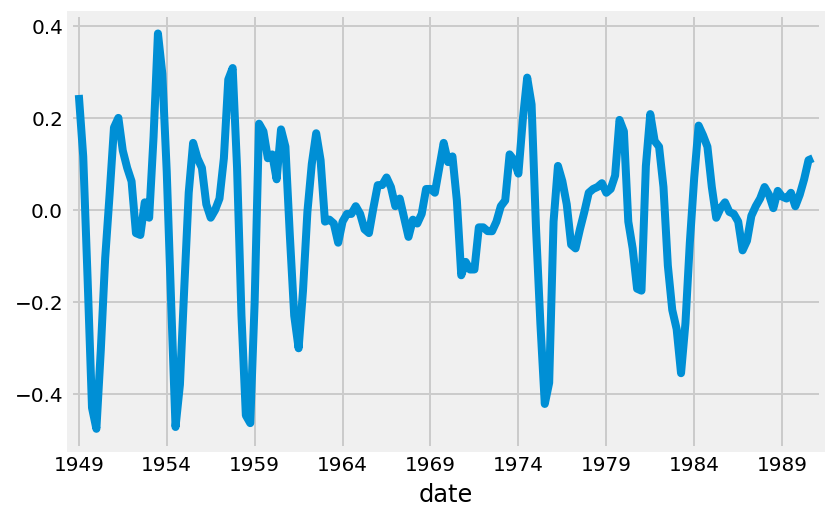

In [34]:
decomp.trend.plot()
plt.show()

### Conclusions

Time series decomposition and analysis of autocorrelations will be the starting point of any time series analysis. They will give us useful information about which model to use.